In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from collections import Counter

import torch
from transformers import AutoTokenizer, AutoModel

from src.utils import *
from src.config import Config

CONFIG:Config = Config()

/Users/matteoperiani/miniconda3/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_agg = pd.read_pickle(CONFIG.dataset.train_data_agg)
df_agg.head()

,post,targetMinority,targetCategory,targetStereotype,whoTarget,intentYN,sexYN,offensiveYN,hasBiasedImplication
0,"\n\nBill Kristol and Ben Shaprio, two turds in...",[],[],[],0.0,0.886667,0.0,1.000000,1
1,\n\nRose\n🌹Taylor‏ @RealRoseTaylor 6h6 hours a...,[],[],[],NaN,0.220000,0.0,0.000000,1
2,\nCharlie Kirk‏\n\nJohnny Depp calls for death...,"[liberals, liberals]","[social, social]","[miscontrue things, take things in a weird way]",1.0,1.000000,0.0,1.000000,0
3,\nDavid Knight‏ \n\nNotice how quickly things ...,[],[],[],0.0,0.110000,0.0,0.166667,1
4,\nFinland fireball: Time-lapse video shows nig...,[],[],[],NaN,0.000000,0.0,0.000000,1


In [23]:
min_counter, min_emb = get_minorities_embedding(df_agg)

857

First aggregation

In [9]:
min_counter, min_emb, sim_minorities, minorities_map = aggregate_minority(min_counter, min_emb, tresh=0.9)
len(min_counter)

734

Second aggregation

In [24]:
min_counter, min_emb, sim_minorities, minorities_map = aggregate_minority(min_counter, min_emb, tresh=0.85)
len(min_counter)

622

Third..

In [26]:
min_counter, min_emb, sim_minorities, minorities_map = aggregate_minority(min_counter, min_emb, tresh=0.8)
len(min_counter)

527

## Data pruning

In [12]:
df = pd.read_pickle(CONFIG.dataset.train_data_preproc)
pruned_df = remove_post_from_annotation_count(df, 1)
print(len(pruned_df))
# pruned_df = remove_post_from_annotation_count(pruned_df, 2)
# print(len(pruned_df))
pruned_df = df_aggregator(pruned_df)
print(len(pruned_df))

Removed posts: 1150
111750
34354


In [13]:
min_counter, min_emb = get_minorities_embedding(pruned_df)
len(min_counter)

801

In [14]:
min_counter, min_emb, sim_minorities, minorities_map = aggregate_minority(min_counter, min_emb, tresh=0.9)
len(min_counter)

688

In [17]:
emb1 = min_emb["women who have had miscarriages"]
emb2 = min_emb["miscarriage victims"]

cosine_similarity(emb1, emb2)

0.81072056

In [18]:
min_counter["miscarriage victims"]

1

In [16]:
for idx, row in pruned_df.iterrows():
    if "women who have had miscarriages" in row["targetMinority"]:
        print(row)

post                    What's red, 10 inches long, and makes your gir...
targetMinority          [miscarriage victims, women who have had misca...
targetCategory                                           [victim, victim]
targetStereotype        [trivializes harm to victims, trivializes harm...
whoTarget                                                             1.0
intentYN                                                              1.0
sexYN                                                                 0.0
offensiveYN                                                           1.0
hasBiasedImplication                                                    0
Name: 25990, dtype: object


In [15]:
min_counter

Counter({'black folks': 12056,
         'women': 8601,
         'jewish folks': 3999,
         'muslim folks': 1905,
         'gay men': 1438,
         'asian folks': 1216,
         'latino/latina folks': 1043,
         'physically disabled folks': 1034,
         'liberals': 733,
         'mentally disabled folks': 697,
         'lesbian women': 607,
         'folks with mental illness/disorder': 531,
         'christian folks': 445,
         'assault victims': 429,
         'mass shooting victims': 415,
         'trans women': 402,
         'native american/first nation folks': 402,
         'arabic folks': 378,
         'immigrants': 358,
         'terrorism victims': 341,
         'overweight/fat folks': 339,
         'trans men': 295,
         'folks with physical illness/disorder': 285,
         'feminists': 283,
         'africans': 236,
         'ethiopians': 236,
         'men': 214,
         'bisexual women': 195,
         'holocaust victims': 178,
         'conservatives': 16

## TSNE
Original embedding

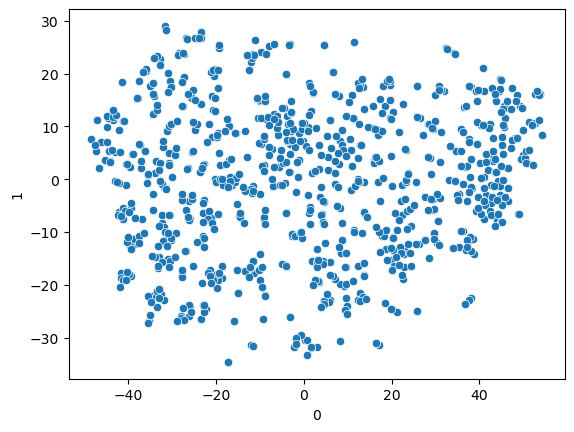

In [32]:
tsne = TSNE(n_components=2)
low_dim_data = tsne.fit_transform(embeddings)
tsne_df =  pd.DataFrame(low_dim_data)
ax = sns.scatterplot(data=tsne_df, x=0, y=1)

Reduced

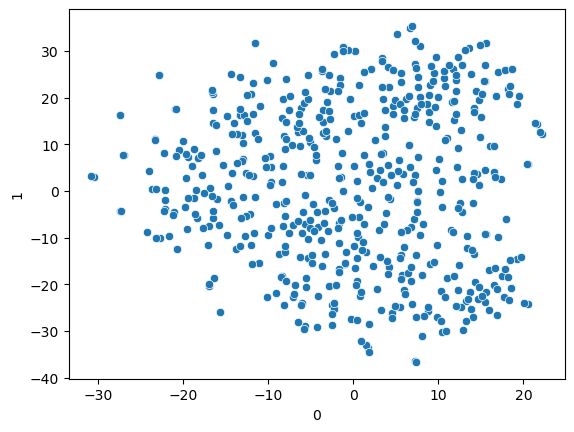

In [31]:
low_dim_data = tsne.fit_transform(np.asarray([emb for _,emb in min_emb.items()]))
tsne_df =  pd.DataFrame(low_dim_data)
ax = sns.scatterplot(data=tsne_df, x=0, y=1)

## PCA

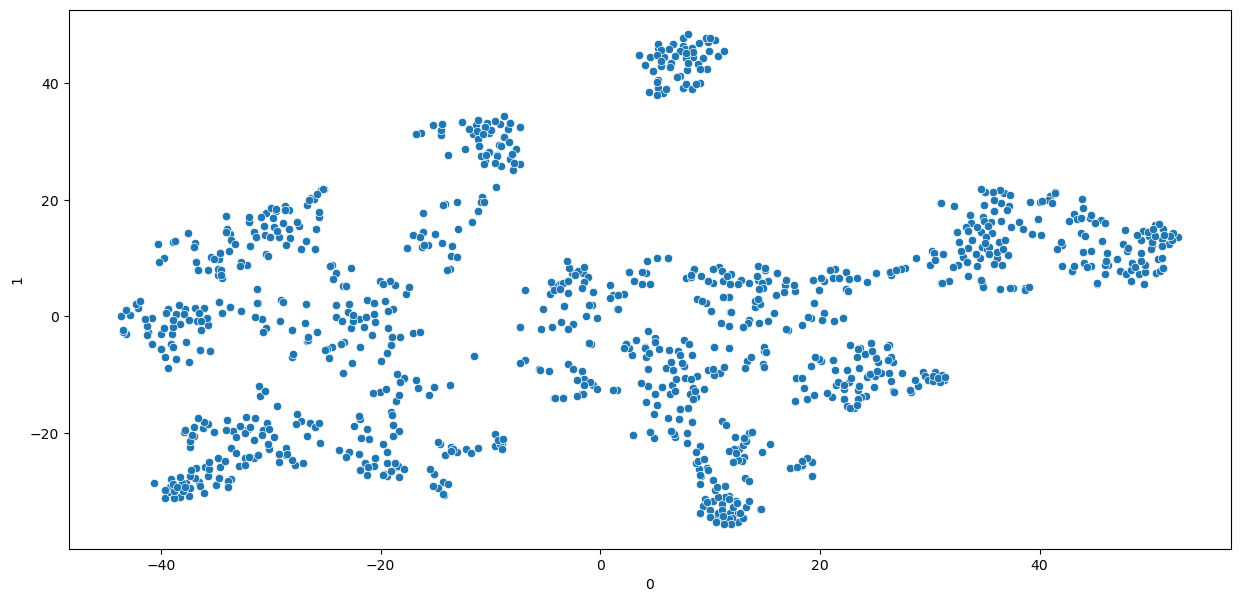

In [257]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# U, S, V = np.linalg.svd(embeddings)
# print(S)

pca = PCA(n_components=8)
pca_embs = pca.fit_transform(embeddings)

pca_cat_emb = {k: v for k,v in zip(minorities, pca_embs)}

tsne = TSNE(n_components=2)
low_dim_data = tsne.fit_transform(pca_embs)

# pca_cat_emb = {k: v for k,v in zip(categories, low_dim_data)}
pca_tsne_df =  pd.DataFrame(low_dim_data)
pca_tsne_df["labels"] = minorities

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.scatterplot(data=pca_tsne_df.loc[3:5], x=0, y=1, color="red", ax=ax)
sns.scatterplot(data=pca_tsne_df, x=0, y=1, ax=ax)
plt.show()

In [254]:
mask = tsne_df[0]>30
tsne_df[mask]

,0,1,labels
9,45.760979,10.868467,assault victims
17,33.159660,11.844923,OD victims
26,34.919216,21.280949,Holocaust victims
27,47.970161,5.965205,rape victims
32,49.191006,5.653676,sex trafficking victims
...,...,...,...
1144,33.561005,13.202026,Fire victims
1147,50.945354,13.994791,"harassment victims, rape victims"
1152,34.970299,15.520514,Boston Marathon victims
1153,36.328423,11.592240,AIDS victims


In [241]:
sim_minorities = {cat: set() for cat in minorities}

for cat1, emb1 in pca_cat_emb.items():
    sim_cat = []
    for cat2, emb2 in pca_cat_emb.items():
        if cat1 != cat2:
            cos_sim = np.dot(emb1, emb2)/(np.linalg.norm(emb1)*np.linalg.norm(emb2))
            if cos_sim > 0.91:
                sim_cat.append(cat2)
    sim_minorities[cat1].update(sim_cat)

In [226]:
sim_minorities.keys()

dict_keys(['liberals', 'middle eastern folks', 'muslim folks', 'muslim folks, arabic folks', 'immigrants', 'women', 'trans women, trans men', 'folks with physical illness/disorder', 'latino/latina folks', 'assault victims', 'black folks', 'Men', 'prisoners', 'white folks', 'mentally disabled folks', 'physically disabled folks', 'folks with mental illness/disorder', 'OD victims', 'lesbian women, gay men, trans women, trans men, bisexual women, bisexual men', 'ugly folks', 'Gypsies', 'gypsies', 'gay men', 'politicians', 'conservatives', 'old folks', 'Holocaust victims', 'rape victims', 'jewish folks', 'conservatives, alt right', 'americans', 'furries', 'sex trafficking victims', 'refugees', 'trans men', 'syrian', 'syrians', 'married folks', 'jamaican folks', 'illegal immigrants', 'asian folks', 'Africans', 'men', 'Islam', 'White folks', 'Thai', 'mass shooting victims', 'overweight/fat folks', 'cancer victims', 'everyone', 'single mothers', 'vegans', 'well off folks', 'White people', 'mur

In [243]:
sim_minorities["African folks"]

{'Mexican people',
 'aboriginal folks',
 'african folks',
 'african people',
 'brown folks',
 'haitians',
 'indigenous folks',
 'jamaican folks',
 'mexican people'}